In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pathlib

In [2]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')


GPU is available
Number of available GPUs: 1
GPU 0: {'device_name': 'NVIDIA GeForce RTX 3060 Ti', 'compute_capability': (8, 6)}


In [3]:
import os
os.getcwd()

'd:\\SoftCom_Assignment01\\Code'

In [4]:
data_dir = 'd:\\SoftCom_Assignment01\\Dataset'
os.listdir(data_dir)

['COVID', 'NORMAL', 'PNEUMONIA']

In [5]:
tf.random.set_seed(42)

train_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'training', seed = 1, shuffle = True, batch_size = 32, image_size=(256,256))

test_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'validation', seed = 1, shuffle = True, batch_size = 32, image_size=(256,256))

Found 5228 files belonging to 3 classes.
Using 4706 files for training.
Found 5228 files belonging to 3 classes.
Using 522 files for validation.


In [6]:
filenames = pathlib.Path(data_dir)
for label in train_data.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

COVID : 1626
NORMAL : 1802
PNEUMONIA : 1800


In [7]:
train_data.cardinality().numpy(),  test_data.cardinality().numpy()

(148, 17)

In [8]:
train_set = train_data.take(120)
val_set = train_data.skip(120)

In [9]:
train_set.cardinality().numpy(), val_set.cardinality().numpy()

(120, 28)

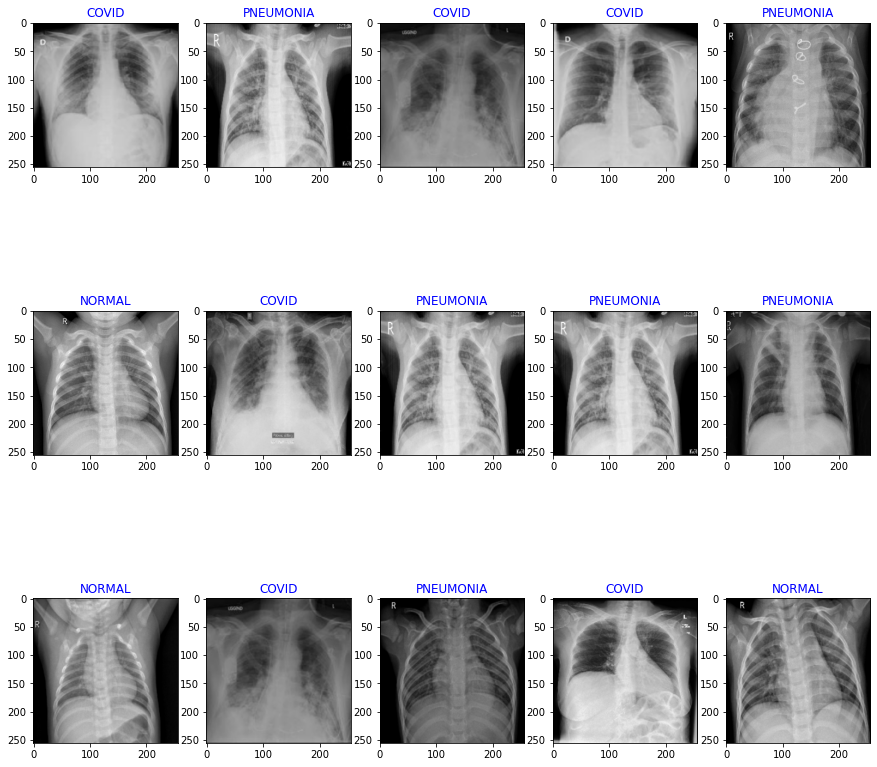

In [11]:
# print random images from the train set
plt.figure(figsize = (15, 15))
for images, labels in train_set.take(1):
    for i in range(15):
        index = random.randint(0, len(images))
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[index]], color= 'blue', fontsize= 12)
        plt.axis(True)
plt.show()

In [12]:
for images_batch, labels_batch in train_set:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [13]:
from tensorflow.keras import layers

In [14]:
tf.random.set_seed(42)

model = keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(128,(3,3), activation='relu', input_shape=(256,256,3)), # Hidden Layer 1
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(64,(3,3), activation='relu'), # Hidden Layer 2
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(32,(3,3), activation='relu'), # Hidden Layer 3
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(), # Output layer
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

In [15]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics = 'accuracy')

In [16]:
history_1 = model.fit(train_set, epochs=25, validation_data=val_set)

Epoch 1/25
120/120 [==============================] - 18s 100ms/step - loss: 0.6582 - accuracy: 0.6966 - val_loss: 0.2802 - val_accuracy: 0.9053
Epoch 2/25
120/120 [==============================] - 12s 98ms/step - loss: 0.3223 - accuracy: 0.8891 - val_loss: 0.2225 - val_accuracy: 0.9261
Epoch 3/25
120/120 [==============================] - 12s 98ms/step - loss: 0.2225 - accuracy: 0.9219 - val_loss: 0.1634 - val_accuracy: 0.9411
Epoch 4/25
120/120 [==============================] - 12s 97ms/step - loss: 0.1868 - accuracy: 0.9354 - val_loss: 0.1666 - val_accuracy: 0.9446
Epoch 5/25
120/120 [==============================] - 12s 97ms/step - loss: 0.1735 - accuracy: 0.9396 - val_loss: 0.1480 - val_accuracy: 0.9561
Epoch 6/25
120/120 [==============================] - 12s 97ms/step - loss: 0.1361 - accuracy: 0.9591 - val_loss: 0.1424 - val_accuracy: 0.9503
Epoch 7/25
120/120 [==============================] - 12s 97ms/step - loss: 0.1168 - accuracy: 0.9633 - val_loss: 0.1247 - val_accuracy

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0

In [18]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

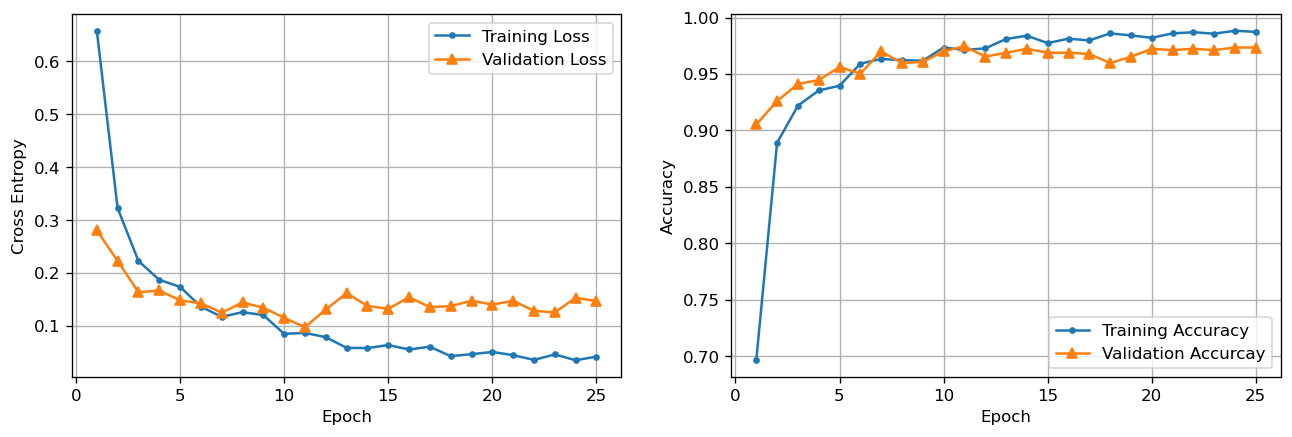

In [19]:
plot_training_curves(pd.DataFrame(history_1.history))

In [20]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)
        
X_test.shape, y_test.shape

(TensorShape([522, 256, 256, 3]), TensorShape([522]))

In [21]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [22]:
test_score = model.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

17/17 [==============================] - 1s 31ms/step - loss: 0.1615 - accuracy: 0.9674
Test Loss:  0.1615048497915268
Test Accuracy:  0.967432975769043


In [23]:
from sklearn.metrics import classification_report
target_names = ['COVID', 'NORMAL', 'PNEUMONIA']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

       COVID       0.99      0.97      0.98       163
      NORMAL       0.94      0.99      0.96       177
   PNEUMONIA       0.97      0.95      0.96       182

    accuracy                           0.97       522
   macro avg       0.97      0.97      0.97       522
weighted avg       0.97      0.97      0.97       522



In [24]:
# plot random images from a given dataset, and compare predictions with ground truth
def plot_random_predictions(dataset, model):

    shuffled_data = dataset.shuffle(10)
    class_names = dataset.class_names

    for images, labels in shuffled_data.take(1):
        plt.figure(figsize = (10, 10), dpi = 120)
        y_pred_proba = model.predict(images)

    for i in range(9):
        index = random.randint(0, len(images))
        ax = plt.subplot(3,3, i + 1)

        img = images[index].numpy().astype("uint8")
        y_true = class_names[labels[index]]
        y_pred = class_names[np.argmax(y_pred_proba[index], axis = 0)]
      
        c = 'g' if y_pred == y_true else 'r'
      
        plt.imshow(img)
        plt.title(f'Predicted : {y_pred}\nTrue label : {y_true}', c = c)
        plt.axis(False)

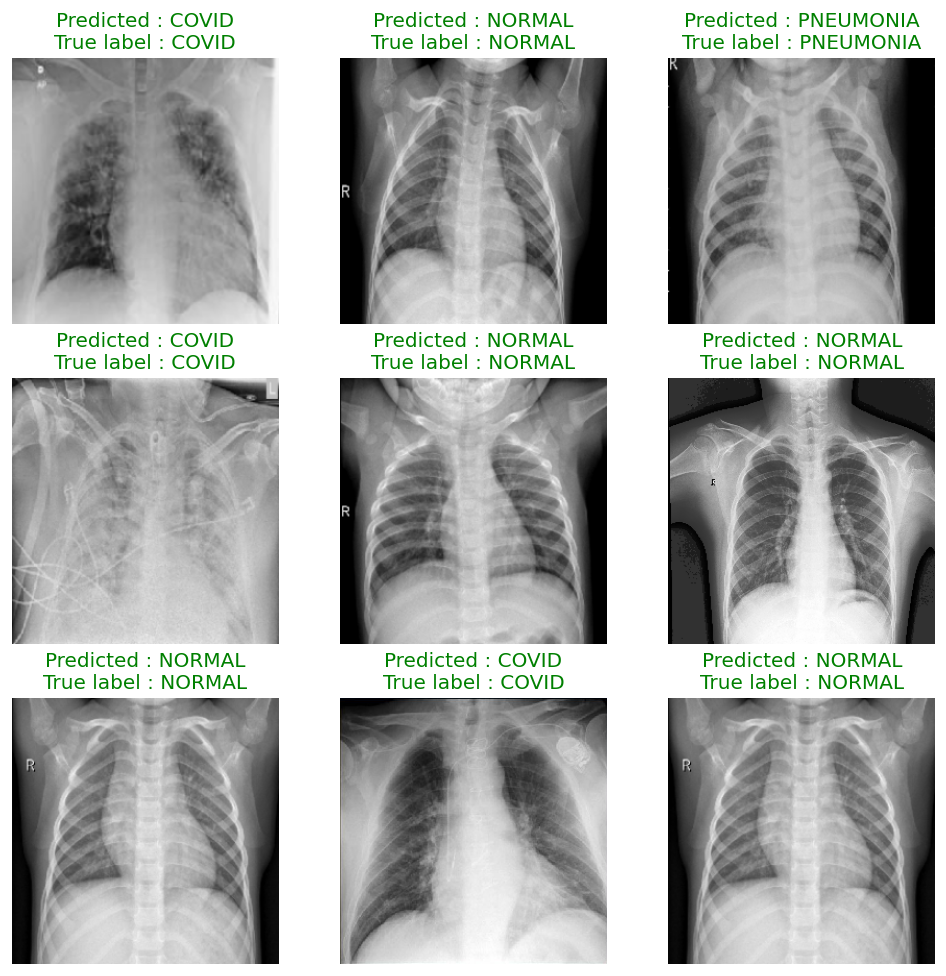

In [26]:
plot_random_predictions(test_data, model)

In [28]:
model.save('d:\\SoftCom_Assignment01\\\Model\\cnnModel.h5')